In [72]:
import pandas as pd
import numpy as np
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
import seaborn as sns
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings  
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [57]:
data = pd.read_excel("output.xlsx")

In [58]:
data.columns

Index(['Created On', 'Order Item ', ' Quantity', 'Order Item'], dtype='object')

In [59]:
data['Ordered Time'] = data['Created On'].dt.round('60min')  


In [60]:
data.head()

,Created On,Order Item,Quantity,Order Item,Ordered Time
0,2019-01-10 10:27:07,sedona salad,1,sedona salad,2019-01-10 10:00:00
1,2019-01-10 16:48:23,Canned Soda,1,canned soda,2019-01-10 17:00:00
2,2019-01-10 16:52:28,Canned Soda,1,canned soda,2019-01-10 17:00:00
3,2019-01-10 17:00:10,2 Liter Soda,1,2 liter soda,2019-01-10 17:00:00
4,2019-01-10 17:20:27,Cheese Pizza,1,cheese pizza,2019-01-10 17:00:00


In [61]:
data = data.set_index('Ordered Time')

In [62]:
data.drop(columns=['Order Item ','Created On'],inplace=True)

In [63]:
data.head()

,Quantity,Order Item
Ordered Time,,
2019-01-10 10:00:00,1,sedona salad
2019-01-10 17:00:00,1,canned soda
2019-01-10 17:00:00,1,canned soda
2019-01-10 17:00:00,1,2 liter soda
2019-01-10 17:00:00,1,cheese pizza


In [64]:
data.dtypes

 Quantity      int64
Order Item    object
dtype: object

In [65]:
data.shape

(1697, 2)

In [66]:
data.describe()

,Quantity
count,1697.000000
mean,1.057749
std,0.266375
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,5.000000


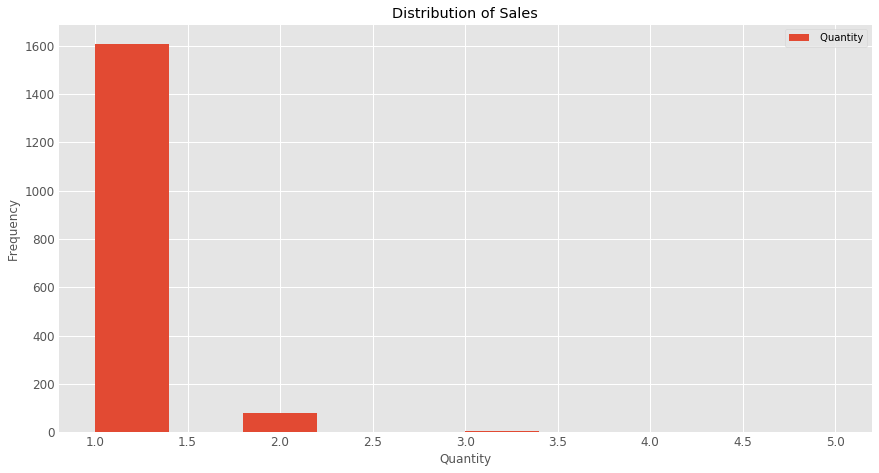

In [67]:
_=data.plot.hist(figsize=(13, 7), title='Distribution of Sales')
plt.xlabel('Quantity')
plt.show()


In [105]:
def plot_prediction(actual, prediction, start_date, end_date, title, prediction_label):
    plt.figure(figsize=(20,5))
    plt.title(title)
    plt.plot(y_test.index, y_test, label='Actual')
    plt.plot(y_test.index, prediction, label=prediction_label)
    plt.ylabel('Power(MW)')
    plt.xlabel('Datetime')
    plt.legend()
    plt.xlim(left= start_date, right=end_date)
    plt.show()
    
def subplot_prediction(actual, prediction,prediction_label):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
    
    con_df = pd.concat([actual.rename('Actual'),pd.DataFrame(prediction, index=actual.index, columns=[prediction_label])], axis=1)
    axes[0].set_title('Actual vs Prediction - One day')
    axes[0].set_ylabel('Power(MW)')
    axes[0].set_xlabel('Datetime')
    con_df.plot(ax=axes[0])
    axes[0].set_xlim(left=con_df.index[-24*1] , right=con_df.index[-1])
    
    axes[1].set_title('Actual vs Prediction - One week')
    axes[1].set_ylabel('Power(MW)')
    axes[1].set_xlabel('Datetime')
    con_df.plot(ax=axes[1])
    axes[1].set_xlim(left=actual.index[-24*7] , right=actual.index[-1])
    
    axes[2].set_title('Actual vs Prediction - One month')
    axes[2].set_ylabel('Power(MW)')
    axes[2].set_xlabel('Datetime')
    con_df.plot(ax=axes[2])
    axes[2].set_xlim(left=actual.index[-24*7*4] , right=actual.index[-1])
    
    plt.tight_layout()
    plt.show()
    
def plot_feature_importances( clf, X_train, y_train=None
                             ,top_n=10, figsize=(10,18), print_table=False, title="Feature Importances"):
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by='importance', ascending=False))
        
    return feat_imp


In [106]:
final_df = (data.assign( day_of_week = data.index.dayofweek
                            ,year = data.index.year
                            ,month = data.index.month
                            ,day = data.index.day
                            ,day_of_year = data.index.dayofyear
                            ,week = data.index.week
                            ,week_day = data.index.weekday_name 
                            ,quarter = data.index.quarter
                            ,hour = data.index.hour
                            ,hour_x = np.sin(2.*np.pi*data.index.hour/24.)
                            ,hour_y = np.cos(2*np.pi*data.index.hour/24.)
                            ,day_of_year_x = np.sin(2.*np.pi*data.index.dayofyear/365.)
                            ,day_of_year_y = np.cos(2.*np.pi*data.index.dayofyear/365.)

                          )
           )


In [132]:
final_df.tail()

,Quantity,Order Item,day_of_week,year,month,day,day_of_year,week,week_day,quarter,hour,hour_x,hour_y,day_of_year_x,day_of_year_y
Ordered Time,,,,,,,,,,,,,,,
2019-09-22 20:00:00,1,spaghetti,6,2019,9,22,265,38,Sunday,3,20,-0.866025,5.000000e-01,-0.988678,-0.150055
2019-09-23 18:00:00,1,caesar salad,0,2019,9,23,266,39,Monday,3,18,-1.000000,-1.836970e-16,-0.991114,-0.133015
2019-09-23 18:00:00,2,tamato basil soup,0,2019,9,23,266,39,Monday,3,18,-1.000000,-1.836970e-16,-0.991114,-0.133015
2019-09-23 18:00:00,1,caesar salad,0,2019,9,23,266,39,Monday,3,18,-1.000000,-1.836970e-16,-0.991114,-0.133015
2019-09-23 18:00:00,1,soda,0,2019,9,23,266,39,Monday,3,18,-1.000000,-1.836970e-16,-0.991114,-0.133015


Exception ignored in: <function DMatrix.__del__ at 0x0000020DCAA789D8>
Traceback (most recent call last):
  File "C:\Users\Gracy\Anaconda3\lib\site-packages\xgboost\core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <function DMatrix.__del__ at 0x0000020DCAA789D8>
Traceback (most recent call last):
  File "C:\Users\Gracy\Anaconda3\lib\site-packages\xgboost\core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


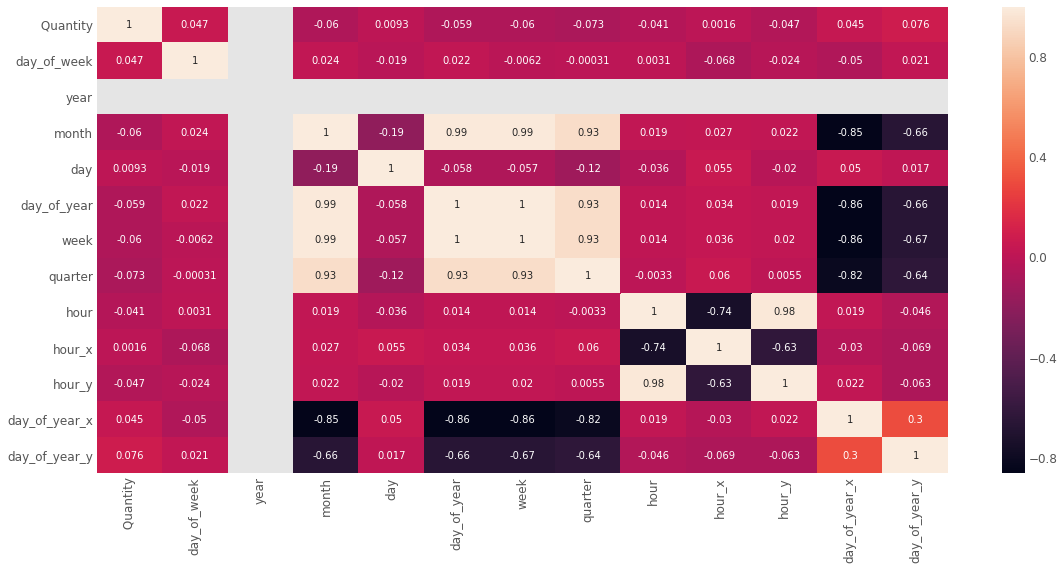

In [108]:
fig, ax = plt.subplots(figsize = (17,8))
corr = final_df.corr()
ax = sns.heatmap(corr, annot=True,
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values)
plt.show()


In [109]:
X = final_df.drop(columns=[' Quantity','Order Item','week_day'])
y = final_df[' Quantity']

In [110]:
print(X.shape)
print(y.shape)

(1697, 12)
(1697,)


In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


In [112]:
reg = xgb.XGBRegressor()


In [113]:
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(reg, X.values, y.values, cv=tscv
                         ,scoring='explained_variance'
                        )
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() ))
print(scores)

Accuracy: -0.16 (+/- 0.17)
[-0.23889479 -0.45000484 -0.03949787 -0.06137494  0.00389619]


In [114]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)


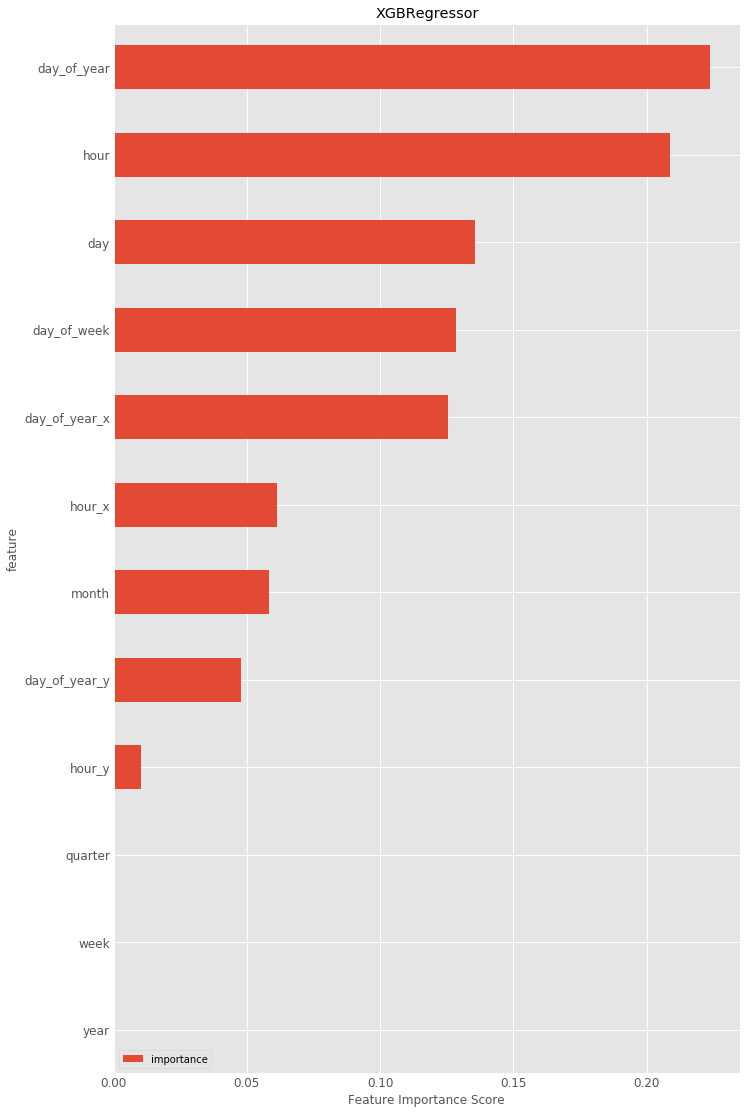

Top 12 features in descending order of importance


,importance
feature,
day_of_year,0.223881
hour,0.208955
day,0.135821
day_of_week,0.128358
day_of_year_x,0.125373
hour_x,0.061194
month,0.058209
day_of_year_y,0.047761
hour_y,0.010448


In [115]:
_ = plot_feature_importances(reg, X_train, y_train, top_n=X_train.shape[1], title=reg.__class__.__name__, print_table=True)


In [116]:
def get_features(date, comb_df):
    features = comb_df.loc[date]
    features = (features.assign(
                                day_of_week = features.index.dayofweek
                                ,year = features.index.year
                                ,month = features.index.month
                                ,day = features.index.day
                                ,day_of_year = features.index.dayofyear
                                ,week = features.index.week
#                                             ,week_day = features.index.weekday_name 
                                ,quarter = features.index.quarter
                                ,hour = features.index.hour
                                ,hour_x = np.sin(2.*np.pi*features.index.hour/24.)
                                ,hour_y = np.cos(2*np.pi*features.index.hour/24.)
                                ,day_of_year_x = np.sin(2.*np.pi*features.index.dayofyear/365.)
                                ,day_of_year_y = np.cos(2.*np.pi*features.index.dayofyear/365.)
                                
                                ))
    
    for day in range(8):
        features['temperature_d' + str(day)] = comb_df.temperature.shift(24*day)
        features['wind_speed_d' + str(day)] = comb_df.wind_speed.shift(24*day)
        features['humidity_d' + str(day)] = comb_df.humidity.shift(24*day)
        features['pressure_log_d' + str(day)] = comb_df.pressure_log.shift(24*day)



        features['load_d' subplot_prediction(y_test, prediction,prediction_label='XGB model prediction')+ str(day)] = comb_df.PJME_MW.shift(24*day)

    features = features.dropna()
    
    features = features.drop(columns=['temperature', 'wind_speed', 'humidity', 'pressure', 'wind_direction','PJME_MW'])

    return features


IndexError: index -672 is out of bounds for axis 0 with size 510

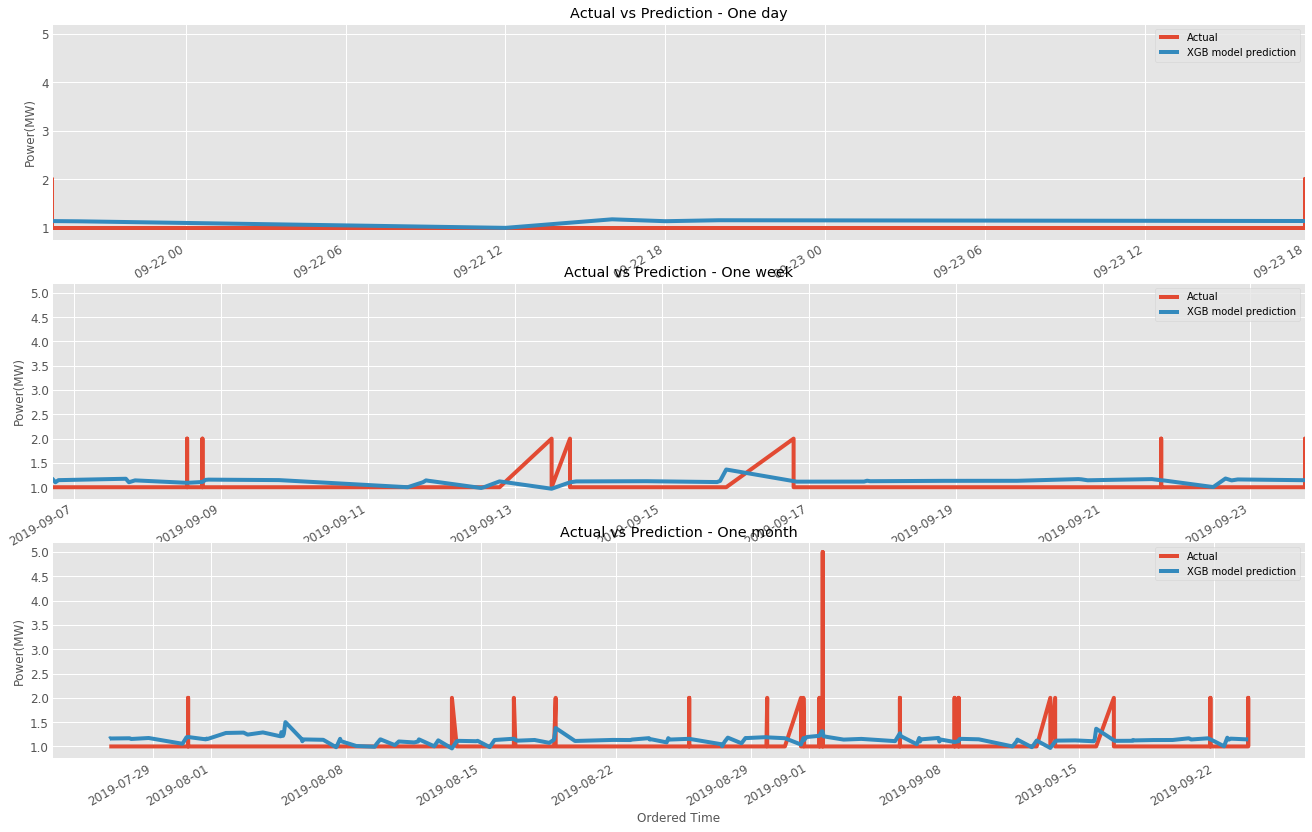

In [117]:
subplot_prediction(y_test, prediction,prediction_label='XGB model prediction')


In [118]:
reg = AdaBoostRegressor()
tscv = TimeSeriesSplit(n_splits=10)
scores = cross_val_score(reg, X, y, cv=tscv
                         , scoring='explained_variance'
                        )
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() ))


Accuracy: -0.32 (+/- 0.48)


In [119]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)


IndexError: index -672 is out of bounds for axis 0 with size 510

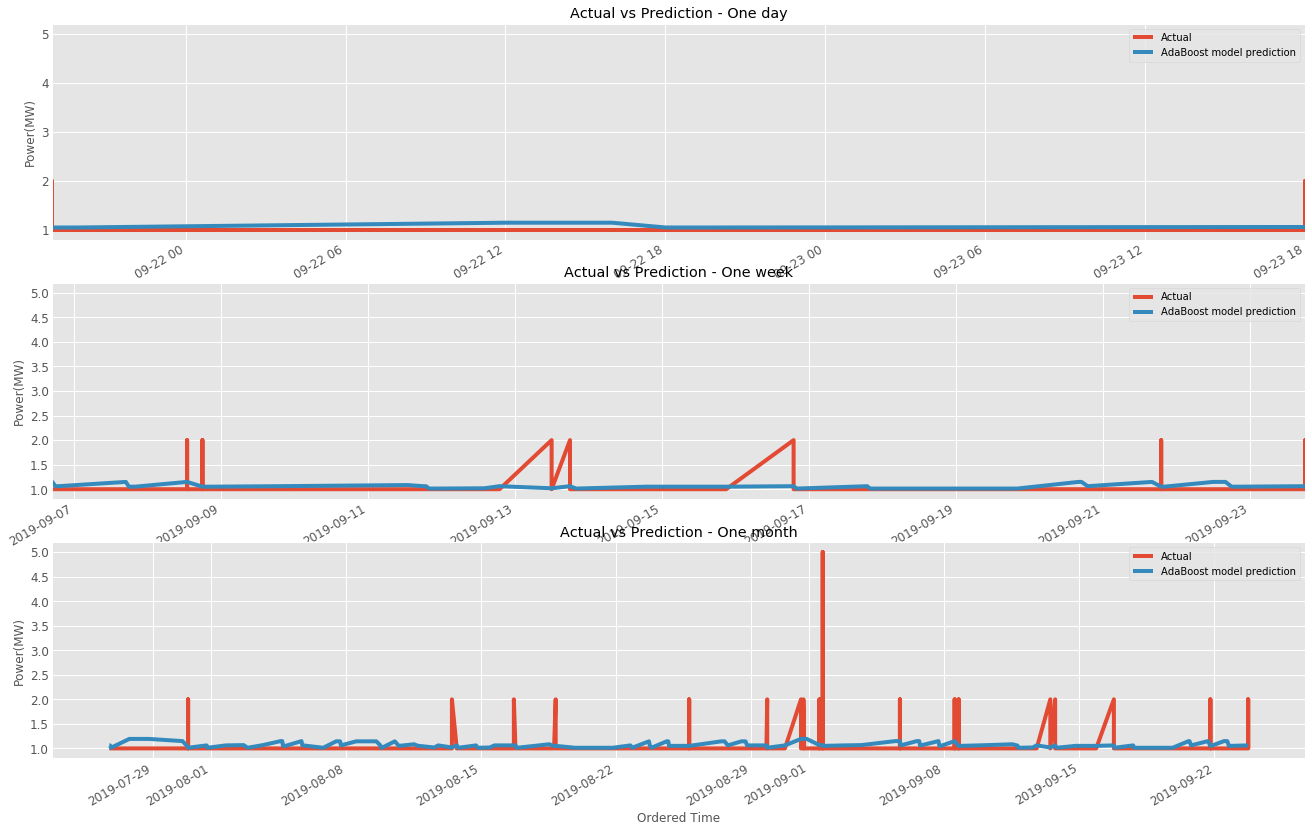

In [120]:
subplot_prediction(y_test, prediction,prediction_label='AdaBoost model prediction')


In [121]:
reg = BaggingRegressor()
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(reg, X, y, cv=tscv, scoring='explained_variance')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() ))
print(scores)


Accuracy: -0.39 (+/- 0.27)
[-0.55975649 -0.58677253 -0.11169967 -0.66710375 -0.00835312]


IndexError: index -672 is out of bounds for axis 0 with size 510

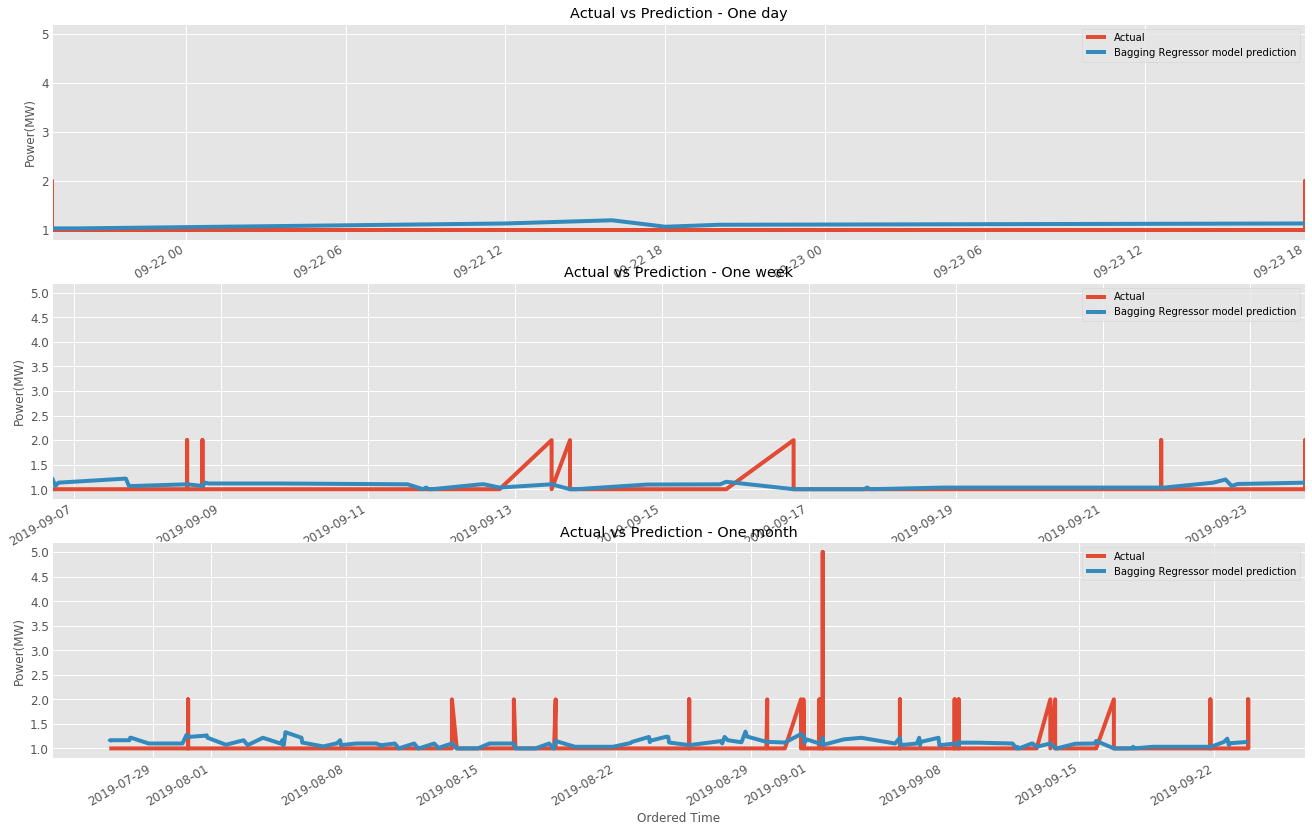

In [122]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)
subplot_prediction(y_test, prediction,prediction_label='Bagging Regressor model prediction')


In [123]:
reg = ExtraTreesRegressor()
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(reg, X, y, cv=tscv, scoring='explained_variance')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() ))


Accuracy: -0.12 (+/- 0.06)


In [124]:
reg.fit(X_train,y_train)
prediction = reg.predict(X_test)


IndexError: index -672 is out of bounds for axis 0 with size 510

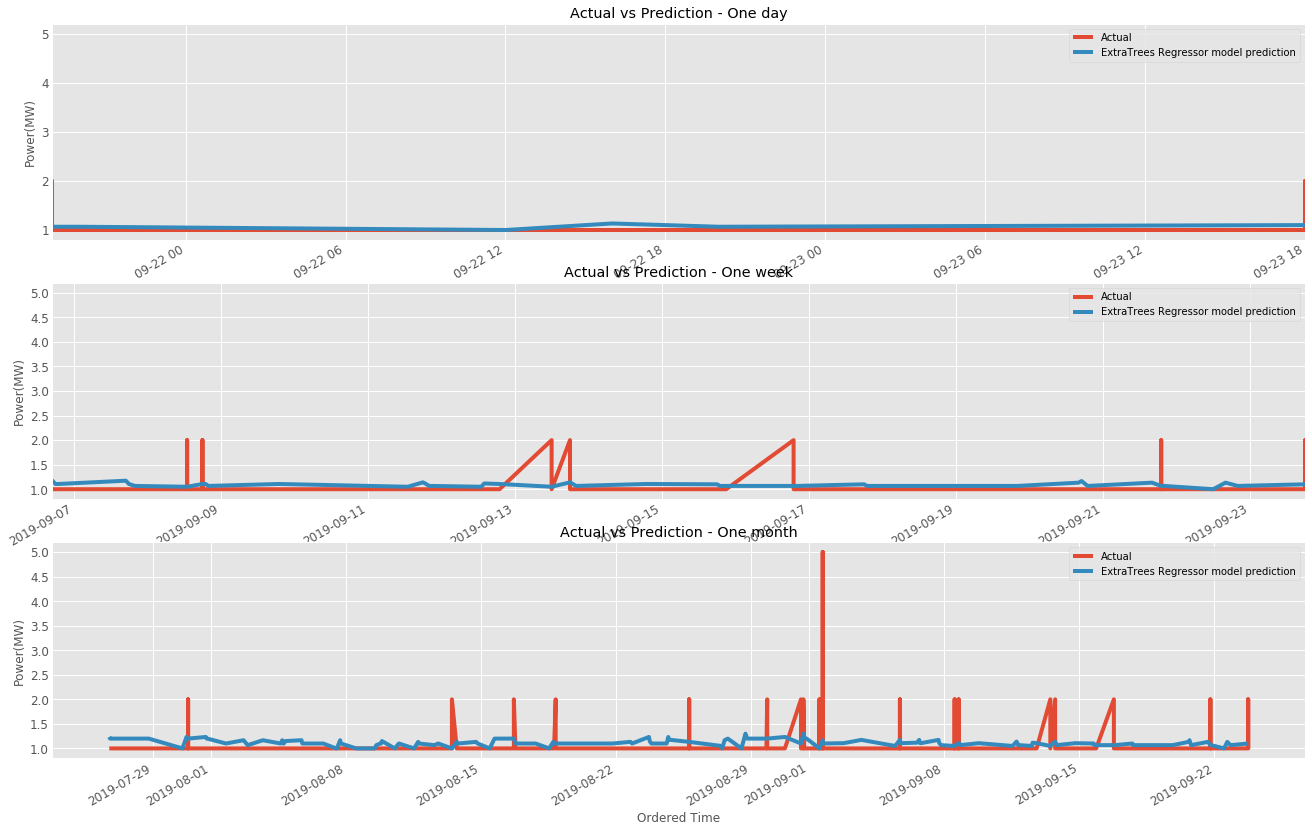

In [125]:
subplot_prediction(y_test, prediction,prediction_label='ExtraTrees Regressor model prediction')


In [126]:
final_df.head()

,Quantity,Order Item,day_of_week,year,month,day,day_of_year,week,week_day,quarter,hour,hour_x,hour_y,day_of_year_x,day_of_year_y
Ordered Time,,,,,,,,,,,,,,,
2019-01-10 10:00:00,1,sedona salad,3,2019,1,10,10,2,Thursday,1,10,0.500000,-0.866025,0.171293,0.98522
2019-01-10 17:00:00,1,canned soda,3,2019,1,10,10,2,Thursday,1,17,-0.965926,-0.258819,0.171293,0.98522
2019-01-10 17:00:00,1,canned soda,3,2019,1,10,10,2,Thursday,1,17,-0.965926,-0.258819,0.171293,0.98522
2019-01-10 17:00:00,1,2 liter soda,3,2019,1,10,10,2,Thursday,1,17,-0.965926,-0.258819,0.171293,0.98522
2019-01-10 17:00:00,1,cheese pizza,3,2019,1,10,10,2,Thursday,1,17,-0.965926,-0.258819,0.171293,0.98522


In [127]:
date = '2019-01-10'
final_df.loc[date].head()


,Quantity,Order Item,day_of_week,year,month,day,day_of_year,week,week_day,quarter,hour,hour_x,hour_y,day_of_year_x,day_of_year_y
Ordered Time,,,,,,,,,,,,,,,
2019-01-10 10:00:00,1,sedona salad,3,2019,1,10,10,2,Thursday,1,10,0.500000,-0.866025,0.171293,0.98522
2019-01-10 17:00:00,1,canned soda,3,2019,1,10,10,2,Thursday,1,17,-0.965926,-0.258819,0.171293,0.98522
2019-01-10 17:00:00,1,canned soda,3,2019,1,10,10,2,Thursday,1,17,-0.965926,-0.258819,0.171293,0.98522
2019-01-10 17:00:00,1,2 liter soda,3,2019,1,10,10,2,Thursday,1,17,-0.965926,-0.258819,0.171293,0.98522
2019-01-10 17:00:00,1,cheese pizza,3,2019,1,10,10,2,Thursday,1,17,-0.965926,-0.258819,0.171293,0.98522


In [130]:
def get_features(date):
    features = final_df.loc[date]
    features = (features.assign(
                                day_of_week = features.index.dayofweek
                                ,year = features.index.year
                                ,month = features.index.month
                                ,day = features.index.day
                                ,day_of_year = features.index.dayofyear
                                ,week = features.index.week
#                                             ,week_day = features.index.weekday_name 
                                ,quarter = features.index.quarter
                                ,hour = features.index.hour
                                ,hour_x = np.sin(2.*np.pi*features.index.hour/24.)
                                ,hour_y = np.cos(2*np.pi*features.index.hour/24.)
                                ,day_of_year_x = np.sin(2.*np.pi*features.index.dayofyear/365.)
                                ,day_of_year_y = np.cos(2.*np.pi*features.index.dayofyear/365.)
                                ))
    return features


In [131]:
prediction = reg.predict(get_features(date))
#idx = .loc[date].index 
prediction.head()

ValueError: could not convert string to float: 'sedona salad'